In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from shapely.geometry import LineString, Point
from common.tools import inegi_projection
from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

/home/arinarmo/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# Load base model
import joblib
from sklearn.base import BaseEstimator, RegressorMixin


class HourLinearEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, hours=[0], hour_col="hour", normalize=True):        
        self.hours = hours
        self.hour_col = hour_col
        self.normalize = normalize
        
        h = [*hours, 24]
        self._start_hours = h[:-1]
        self._end_hours = h[1:]
        
    def fit(self, X, y):
        self._models = []
        for s, e in zip(self._start_hours, self._end_hours):
            idx = (X[self.hour_col] >= s) & (X[self.hour_col] <= e-1)
            model = LinearRegression(normalize=self.normalize)
            model.fit(X[idx], y[idx])
            self._models.append(model)
    
    def predict(self, X, y=None):
        pred = np.zeros(len(X))
        for model, s, e in zip(self._models, self._start_hours, self._end_hours):
            idx = (X[self.hour_col] >= s) & (X[self.hour_col] < e)
            if sum(idx) > 0:
                pred[idx] = model.predict(X[idx])
        return pred

# Load linear model
hle = joblib.load("data/base_model_linear_ensemble.pkl")

In [4]:
# Read the stops
paradas = inegi_projection(pd.read_csv("data/paradas.csv"))
# Add travel distance
route = {
    "outbound": LineString(pd.read_csv("data/ruta_bsf.csv")[["x", "y"]].values),
    "inbound": LineString(pd.read_csv("data/ruta_sfb.csv")[["x", "y"]].values)
}
paradas["distance"] = [route[row.leg].project(Point(row.x, row.y)) for i, row in paradas.iterrows()]
paradas["travel_distance"] = paradas.groupby("leg").distance.shift(-1) - paradas.distance

# Get GDM estimates
gdm = pd.read_csv("data/gdm_estimates.csv")
gdm.timestamp = pd.to_datetime(gdm.timestamp)
gdm["weekend"] = (gdm.timestamp.dt.weekday >= 5).astype(int)
gdm["hour"] = gdm.timestamp.dt.hour
gdm["origin"] = cdist(gdm[["origin_lat", "origin_lon"]], paradas[["latitud", "longitud"]]).argmin(axis=1)

gdm = gdm.groupby(['weekend','origin', 'hour'])[["duration", "duration_in_traffic"]].mean().reset_index()


In [5]:
# Create a DataFrame with all the possible feature combinations
nr = gdm.join(paradas, on="origin")[["origin", "travel_distance", "duration_in_traffic", "weekend", "hour"]]
r = nr.copy()
nr["raining"] = False
r["raining"] = True
full_combo = pd.concat([nr, r])[["origin", "travel_distance", "duration_in_traffic", "weekend", "hour", "raining"]].dropna()

# Use the base model to predict the expected travel time, compute the average speed for each stop
full_combo["travel_time"] = hle.predict(full_combo[["travel_distance", "duration_in_traffic", "weekend", "hour", "raining"]])
full_combo["speed"] = full_combo.travel_distance/full_combo.travel_time
speeds = full_combo.set_index(["weekend", "hour", "raining", "origin"])["speed"]

paradas.loc[paradas.leg == "inbound", "distance"] = paradas.loc[paradas.leg == "inbound", "distance"] + max(paradas.distance[paradas.leg == "outbound"])

In [6]:
from datetime import datetime
from collections import OrderedDict

# Create the environment for the agent, this will simulate the route at the specified conditions.
# At each step, the environment receives an action as a one-hot encoded in a vector of size 4. It will perform this action on the simulation and move it
# forward by `self.interval` seconds.
class Environment(object):
    start_hour = 5
    end_hour = 23
    
    def __init__(self, speeds, stops, route, interval=60, n_outbound=5, n_inbound=5):
        self.speeds = speeds
        self.stops = stops
        self.route = route
        self.outbound_length = route["outbound"].length
        self.inbound_length = route["inbound"].length
        
        self.waiting_outbound = np.zeros(n_outbound)
        self.waiting_inbound = np.zeros(n_inbound)
        self.moving_outbound = np.empty(0)
        self.moving_inbound = np.empty(0)
        self.running = False
        self.interval = interval
        self.last_out = self.last_in = None
        
    def start_episode(self, start=None, raining=False):
        #self.moving_outbound.append(self.waiting_outbound.pop(0))
        self.running = True
        if start is None:
            self.time = datetime.now().replace(hour=self.start_hour, minute=0, second=0, microsecond=0)
        else:
            self.time = start
        self.end = self.time.replace(hour=self.end_hour)
        self.raining = raining
        self.weekend = 1 if self.time.weekday() > 4 else 0
        
    def update_buses(self):
        positions = np.concatenate([self.moving_outbound, self.moving_inbound + self.outbound_length])
        idx = np.searchsorted(self.stops.distance, positions) - 1
        idx[idx < 0] = 0
        speeds = self.speeds.loc[(self.weekend, self.time.hour, self.raining)].loc[idx].values
        
        self.moving_outbound = self.moving_outbound + speeds[0:len(self.moving_outbound)]*self.interval
        self.moving_inbound = self.moving_inbound + speeds[len(self.moving_outbound):]*self.interval
        
        arrived_out = self.moving_outbound >= self.outbound_length
        self.moving_outbound[arrived_out] = 0
        self.waiting_inbound = np.concatenate([self.waiting_inbound, self.moving_outbound[arrived_out]])
        self.moving_outbound = self.moving_outbound[~arrived_out]
        
        arrived_in = self.moving_inbound >= self.inbound_length
        self.moving_inbound[arrived_in] = 0
        self.waiting_outbound = np.concatenate([self.waiting_outbound, self.moving_inbound[arrived_in]])
        self.moving_inbound = self.moving_inbound[~arrived_in]
    
    def _next(self, action):
        # Actions are encoded as a vector of size 4 with only one non-zero element
        # In order: Send no buses, send bus from outbound base, send bus from inbound base, send bus from both bases
        if not self.running:
            raise Exception("Episode is not running!")
        
        assert len(action) == 4, "Length of action must be equal to 4"
        assert sum(action) == 1, "Choose only one action"
        if action[1] == 1 or action[3] == 1:
            if len(self.waiting_outbound > 0):
                self.moving_outbound = np.append(self.moving_outbound, self.waiting_outbound[0])
                self.waiting_outbound = self.waiting_outbound[1:]
                self.last_out = 0 if self.last_out is None else self.last_out + 1
        if action[2] == 1 or action[3] == 1:
            if len(self.waiting_inbound > 0):
                self.moving_inbound = np.append(self.moving_inbound, self.waiting_inbound[0])
                self.waiting_inbound = self.waiting_inbound[1:]
                self.last_in = 0 if self.last_in is None else self.last_in + 1
        
        self.update_buses()
        
        self.time = self.time + pd.Timedelta(seconds=self.interval)
        if self.time > self.end:
            self.running = False
        
    def get_state(self):
        out = self.moving_outbound
        in_ = self.moving_inbound
        out_dist, in_dist = self.get_distances()
        weekend = 1 if self.time.weekday() > 4 else 0
        state = OrderedDict({
            "waiting_out": len(self.waiting_outbound),
            "waiting_in": len(self.waiting_inbound),
            "moving_out": len(self.moving_outbound),
            "moving_in": len(self.moving_inbound),
            "closest_outbound": min([self.outbound_length, *out])/self.outbound_length,
            "farthest_outbound": max([0, *out])/self.outbound_length,
            "closest_inbound": min([self.inbound_length, *in_])/self.inbound_length,
            "farthest_inbound": max([0, *in_])/self.inbound_length,
            "mean_dist_outbound": (sum(out_dist)/len(out_dist))/self.outbound_length,
            "min_dist_outbound": min(out_dist)/self.outbound_length,
            "max_dist_outbound": max(out_dist)/self.outbound_length,
            "mean_dist_inbound": (sum(in_dist)/len(in_dist))/self.inbound_length,
            "min_dist_inbound": min(in_dist)/self.inbound_length,
            "max_dist_inbound": max(in_dist)/self.inbound_length,
            "none_out": 1 if len(self.waiting_outbound) == 0 else 0,
            "none_in": 1 if len(self.waiting_inbound) == 0 else 0,
            "mean_speed": speeds.loc[(weekend, self.time.hour, self.raining)].mean(),
            "hour_minute": self.time.hour + self.time.minute/60,
            "last_out": self.last_out or 0,
            "last_in": self.last_in or 0
        })
        return state
    
    def get_distances(self):
        out_positions = sorted(list(self.moving_outbound))
        out = [0, *out_positions, self.outbound_length]
        out_dist = [x - y for x, y in zip(out[1:], out[:-1])]
        
        in_positions = sorted(list(self.moving_inbound))
        in_ = [0, *in_positions, self.inbound_length]
        in_dist = [x - y for x, y in zip(in_[1:], in_[:-1])]
        
        return out_dist, in_dist
    
    def get_reward(self):
        out_dist, in_dist = self.get_distances()
        return -max(max(out_dist)/self.outbound_length, max(in_dist)/self.inbound_length)

In [7]:
# The base policy agent, triggers a bus departure from each terminal 
#  if there is at least one available and more than `self.interval` minutes have passed since the last departure from that terminal
class BaseAgent(object):
    def __init__(self, interval=15):
        self.last_out = None
        self.last_in = None
        self.interval = interval
        
    def send_or_not(self, last, waiting):
        return (last is None or last > self.interval) and waiting > 0
    def choose_action(self, state):
        send_out = self.send_or_not(self.last_out, state["waiting_out"])
        if send_out:
            self.last_out = 0
        elif self.last_out is not None:
            self.last_out += 1
        
        send_in = self.send_or_not(self.last_in, state["waiting_in"])
        if send_in:
            self.last_in = 0
        elif self.last_in is not None:
            self.last_in += 1
        
        if send_out and send_in:
            action = [0,0,0,1]
        elif send_out:
            action = [0,1,0,0]
        elif send_in:
            action = [0,0,1,0]
        else:
            action = [1,0,0,0]
        
        return action
        

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
start = datetime(year=2017, month=12, day=20, hour=5)

# A function to render an episode produced by the environment `env` and the agent `agent`
def sim_episode(env, agent, start=None, raining=False, file=''):
    fig, ax = plt.subplots()
    fig.set_figheight(9)
    fig.set_figwidth(15)
    ax.axis('off')
    ax.plot(*route["outbound"].xy)
    ax.plot(*route["inbound"].xy)
    env.start_episode(start=start, raining=raining)
    points_out = [route["outbound"].interpolate(bus) for bus in list(env.moving_outbound) + list(env.waiting_outbound)]
    points_in = [route["inbound"].interpolate(bus) for bus in list(env.moving_inbound) + list(env.waiting_inbound)]
    points = points_out + points_in
    scatter = ax.scatter([p.x for p in points], [p.y for p in points], color="red", animated=True)
    def animate(i):    
        if env.running:
            points_out = [route["outbound"].interpolate(bus) for bus in list(env.moving_outbound) + list(env.waiting_outbound)]
            points_in = [route["inbound"].interpolate(bus) for bus in list(env.moving_inbound) + list(env.waiting_inbound)]
            points = points_out + points_in
            if len(points) > 0:
                scatter.set_offsets([[p.x, p.y] for p in points])
            ax.set_title("Time: {} Reward: {}".format(env.time, env.get_reward()))
            action = agent.choose_action(env.get_state())
            env._next(action)
        return scatter, ax

    anim = FuncAnimation(fig, animate, frames=np.arange(0, 1080), interval=100)
    if file:
        anim.save(file)
    else:
        return HTML(anim.to_html5_video()) 
#sim_episode(Environment(speeds, paradas, route), BaseAgent(15), start=start)

In [9]:
# Run an episode and return the list of rewards received by the agent at each step
def run_episode(env, agent, start=None, raining=False, verbose=False):
    env.start_episode(start)
    rewards = []
    i = 0
    while env.running:
        i += 1
        if i%140 == 0 and verbose:
            print("Time: {}, Total Cost: {}".format(env.time, sum(rewards)))
        rewards.append(env.get_reward())
        action = agent.choose_action(env.get_state())
        env._next(action)
        
    if verbose:
        print("Time: {}, Total Cost: {}".format(env.time, sum(rewards)))
    
    return rewards

# Compute rewards for agents using the base policy
intervals = [5, 7, 10, 15]
rewards = []
for interval in intervals:
    rewards.append(run_episode(Environment(speeds, paradas, route), BaseAgent(interval), start=start))
mins = pd.DatetimeIndex(start=start, periods=len(rewards[0]), freq="1 Min")
rewards_df = pd.DataFrame(np.array(rewards).T, columns=["fixed_{}".format(i) for i in intervals])
rewards_df.index = mins

/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.


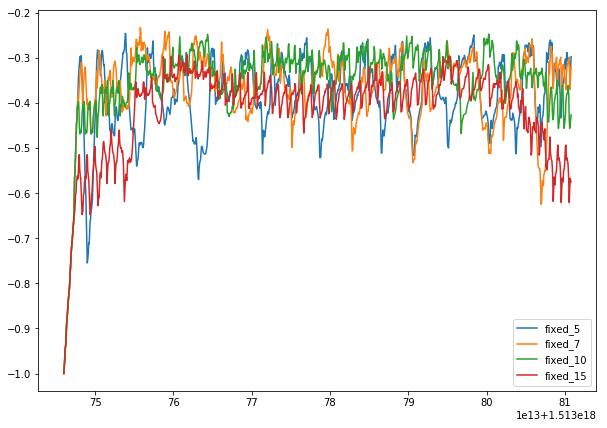

fixed_5    -420.547763
fixed_7    -396.717456
fixed_10   -378.725522
fixed_15   -446.209027
dtype: float64

In [10]:
# Compare the rewards
plt.close()
plt.figure(figsize=(10, 7))
for col in rewards_df.columns:
    plt.plot(rewards_df.index, rewards_df[col], label=col)
plt.legend()
plt.show()

rewards_df.sum()

In [11]:
# This agent implements a similar policy to the above, but chooses a different interval between departures depending on the hour of the day
# We call this a 'mixed' agent because it mixes different base strategies. Not a meaningful term outside this context.
class MixedAgent(object):
    def __init__(self, cuts, intervals):
        self.last_out = None
        self.last_in = None
        self.cuts = cuts
        self.intervals = intervals
        
    def send_or_not(self, last, waiting, hour):
        idx = np.searchsorted(self.cuts, hour) - 1
        interval = self.intervals[idx]
        return (last is None or last > interval) and waiting > 0
    def choose_action(self, state):
        send_out = self.send_or_not(self.last_out, state["waiting_out"], state["hour_minute"])
        if send_out:
            self.last_out = 0
        elif self.last_out is not None:
            self.last_out += 1
        
        send_in = self.send_or_not(self.last_in, state["waiting_in"], state["hour_minute"])
        if send_in:
            self.last_in = 0
        elif self.last_in is not None:
            self.last_in += 1
        
        if send_out and send_in:
            action = [0,0,0,1]
        elif send_out:
            action = [0,1,0,0]
        elif send_in:
            action = [0,0,1,0]
        else:
            action = [1,0,0,0]
        
        return action

mixed_strats = [
    [[0, 8, 18, 21], [7, 10, 15, 10]],
    [[0, 7], [7, 10]],
    [[0, 8, 18, 20], [7, 10, 15, 7]],
    [[0, 8, 18, 20], [7, 9, 15, 7]],
    [[0, 8, 18, 20], [7, 10, 15, 10]]
]
rewards_mixed = []
for strat in mixed_strats:
    rewards_mixed.append(run_episode(Environment(speeds, paradas, route), MixedAgent(*strat), start=start))

rewards_mixed_df = pd.DataFrame(np.array(rewards_mixed).T, columns=["mixed_{}".format(i) for i in range(len(mixed_strats))])
rewards_mixed_df.index = mins

/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.


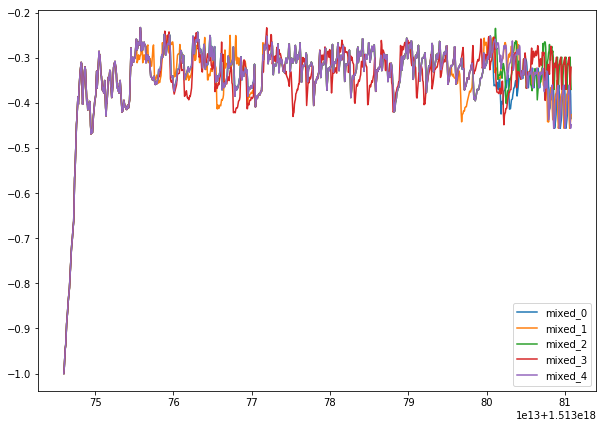

mixed_0   -369.742943
mixed_1   -368.273486
mixed_2   -362.459860
mixed_3   -370.637546
mixed_4   -365.600231
dtype: float64

In [12]:
plt.figure(figsize=(10, 7))
for col in rewards_mixed_df.columns:
    plt.plot(rewards_mixed_df.index, rewards_mixed_df[col], label=col)
plt.legend()
plt.show()
rewards_mixed_df.sum()

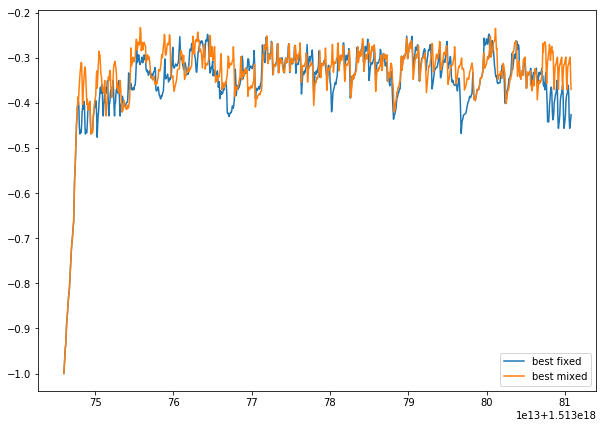

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(rewards_df.index, rewards_df["fixed_10"], label="best fixed")
plt.plot(rewards_mixed_df.index, rewards_mixed_df["mixed_2"], label="best mixed")
plt.legend()
plt.show()

In [14]:
# Implements the network for Q learning. Mostly taken from https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=7, action_size=4, hidden_size=20, name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size, 
                                                         weights_initializer=tf.truncated_normal_initializer(stddev=0.02), scope="fc1")
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, 
                                                         weights_initializer=tf.truncated_normal_initializer(stddev=0.02), scope="fc2")

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None, scope="output")
            
            # Q estimates
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            # Gradient descent step
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            


from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]



In [15]:
# Populates the memory for experience replay purposes
mem_size = 1000000
static_memory = Memory(max_size=mem_size)

p = [0.25, 0.25, 0.25, 0.25]
# Do random shit for a while
pre_train_eps = 4
for i in range(pre_train_eps):
    print("Episode {}".format(i))
    env = Environment(speeds, paradas, route)
    env.start_episode(start=start)
    total_reward = 0
    while env.running:
        state = env.get_state()
        action = np.random.multinomial(1, p)
        env._next(action)
        if not env.running:
            next_state = {}
        else:
            next_state = env.get_state()
        reward = env.get_reward()
        total_reward += reward
        static_memory.add((state, action, reward, next_state))
    
    print("Reward: {}".format(total_reward))

for i in [5, 7, 10, 15]:    
    print("Episode with fixed interval {}".format(i))
    env = Environment(speeds, paradas, route)
    agent = BaseAgent(i)
    env.start_episode(start=start)
    total_reward = 0
    while env.running:
        state = env.get_state()
        action = agent.choose_action(state)
        env._next(action)
        if not env.running:
            next_state  = {}
        else:
            next_state = env.get_state()
        reward = env.get_reward()
        total_reward += reward
        static_memory.add((state, action, reward, next_state)) 
    print("Reward: {}".format(total_reward))

Episode 0


/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.


Reward: -685.9534567582086
Episode 1
Reward: -659.3744450524046
Episode 2
Reward: -691.5084112330699
Episode 3
Reward: -657.9229753156475
Episode with fixed interval 5
Reward: -419.85288066663475
Episode with fixed interval 7
Reward: -396.03086515814414
Episode with fixed interval 10
Reward: -378.1241195822498
Episode with fixed interval 15
Reward: -445.75547682873287


In [41]:
# Q-network hyperparameters
train_episodes = 250
hidden_size = 256 # Size of each hidden layer
state_size = 20 # This must be equal to the size of the state dictionary produced by the Environment
learning_rate=0.0001
gamma = 0.99

# Training parameters
explore_p = 0.05 # Probability of taking a random action
copy_every = 500 # The main network will be cloned after this number of steps
batch_size=32


# Display parameters
print_every = 10
plot_every = 50
save_every = 100
roll_window = int(round(plot_every/4))

/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.


Best reward -733.91
Best reward -617.80
Best reward -594.87
Best reward -517.88
Best reward -452.12
Episode: 10 Total cost: -487.33 Mean episode cost (Last 12): -626.42 Mean loss (Last 5k): 0.0975
Best reward -437.35
Best reward -421.94
Best reward -405.46
Episode: 20 Total cost: -512.67 Mean episode cost (Last 12): -451.03 Mean loss (Last 5k): 0.3164
Episode: 30 Total cost: -441.10 Mean episode cost (Last 12): -471.66 Mean loss (Last 5k): 0.3292
Episode: 40 Total cost: -438.09 Mean episode cost (Last 12): -467.52 Mean loss (Last 5k): 0.3312
Episode: 50 Total cost: -429.02 Mean episode cost (Last 12): -462.73 Mean loss (Last 5k): 0.3576


/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:88: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()


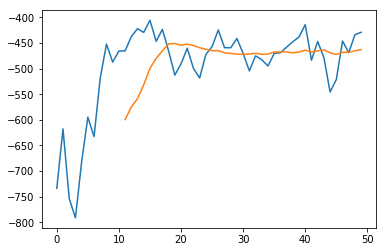

/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:92: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()


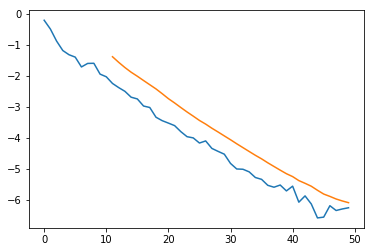

Best reward -398.83
Episode: 60 Total cost: -449.70 Mean episode cost (Last 12): -440.30 Mean loss (Last 5k): 0.3700
Episode: 70 Total cost: -498.90 Mean episode cost (Last 12): -495.59 Mean loss (Last 5k): 0.3394
Episode: 80 Total cost: -480.61 Mean episode cost (Last 12): -477.28 Mean loss (Last 5k): 0.3204
Episode: 90 Total cost: -462.17 Mean episode cost (Last 12): -455.74 Mean loss (Last 5k): 0.3271
Episode: 100 Total cost: -482.97 Mean episode cost (Last 12): -457.83 Mean loss (Last 5k): 0.3016


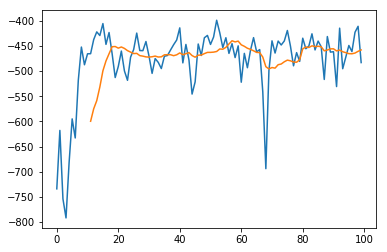

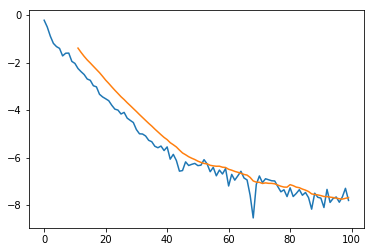

Best reward -387.15
Episode: 110 Total cost: -419.41 Mean episode cost (Last 12): -433.51 Mean loss (Last 5k): 0.3133
Episode: 120 Total cost: -445.56 Mean episode cost (Last 12): -435.11 Mean loss (Last 5k): 0.2993
Episode: 130 Total cost: -451.73 Mean episode cost (Last 12): -458.92 Mean loss (Last 5k): 0.2391
Episode: 140 Total cost: -415.65 Mean episode cost (Last 12): -444.49 Mean loss (Last 5k): 0.3172
Best reward -386.06
Episode: 150 Total cost: -384.14 Mean episode cost (Last 12): -409.91 Mean loss (Last 5k): 0.2788


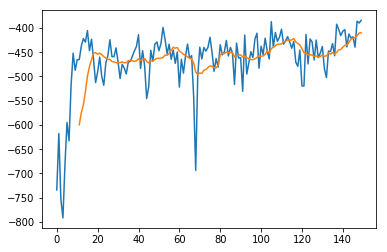

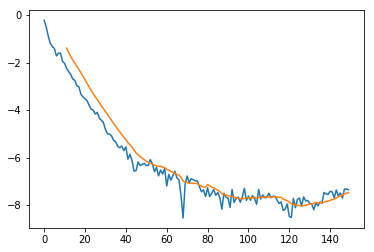

Best reward -384.14
Episode: 160 Total cost: -398.77 Mean episode cost (Last 12): -408.58 Mean loss (Last 5k): 0.2836
Episode: 170 Total cost: -406.30 Mean episode cost (Last 12): -413.23 Mean loss (Last 5k): 0.2580
Episode: 180 Total cost: -410.57 Mean episode cost (Last 12): -411.97 Mean loss (Last 5k): 0.2410
Episode: 190 Total cost: -404.70 Mean episode cost (Last 12): -437.41 Mean loss (Last 5k): 0.1968
Episode: 200 Total cost: -429.89 Mean episode cost (Last 12): -416.09 Mean loss (Last 5k): 0.1832


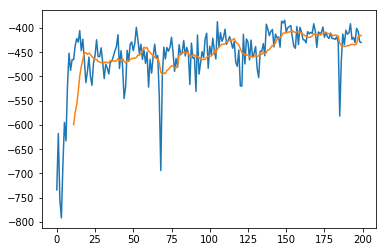

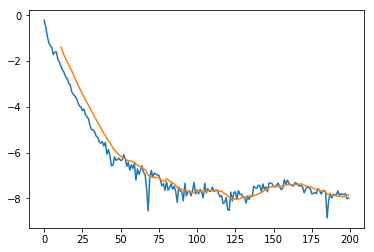

Episode: 210 Total cost: -433.18 Mean episode cost (Last 12): -416.47 Mean loss (Last 5k): 0.2083
Episode: 220 Total cost: -427.80 Mean episode cost (Last 12): -424.42 Mean loss (Last 5k): 0.2147
Episode: 230 Total cost: -486.42 Mean episode cost (Last 12): -433.80 Mean loss (Last 5k): 0.2150
Episode: 240 Total cost: -407.82 Mean episode cost (Last 12): -441.77 Mean loss (Last 5k): 0.2324


In [42]:
# This code is based on https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb 
# It was adapted for our particular case and extended to include the network clone as detailed in http://www.davidqiu.com:8888/research/nature14236.pdf
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate, state_size=state_size)
cloneQN = QNetwork(name='clone', hidden_size=hidden_size, learning_rate=learning_rate, state_size=state_size)
memory = Memory(max_size=mem_size)
memory.buffer = static_memory.buffer.copy()
saver = tf.train.Saver()
rewards_list = []
mean_Qs = []
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Initialize the clone with same weights as the main
    main_vars = tf.trainable_variables("main")
    clone_vars = tf.trainable_variables("clone")
    copy = [c.assign(m.value()) for m, c in zip(main_vars, clone_vars)]
    sess.run(copy)
    step = 0
    for ep in range(1, train_episodes):
        env = Environment(speeds, paradas, route)
        env.start_episode(start=start)
        env._next([0, 0, 0, 1]) # Get stuff moving
        episode_reward = 0
        Q_sum = []
        while env.running:
            step += 1
            state = env.get_state()
            if explore_p > np.random.rand():
                action = list(np.random.multinomial(1, p)).index(1)
            else:
                # Use main network to choose an action
                feed = {mainQN.inputs_: [list(state.values())]}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                Q_sum.extend(Qs[0])
                action = np.argmax(Qs)
            action_oh = np.zeros(4)
            action_oh[action] = 1
            env._next(action_oh)
            next_state = env.get_state()
            reward = env.get_reward()
                
            episode_reward += reward
            memory.add((state, action_oh, reward, next_state))
            
            batch = memory.sample(batch_size) 
            state_dicts = [each[0] for each in batch]
            states = np.array([list(each.values()) for each in state_dicts])
            actions = np.array([list(each[1]).index(1) for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_state_dicts = [each[3] for each in batch]
            next_states = np.array([list(each.values()) if each else np.zeros(state_size) for each in next_state_dicts])
            
            # Use the clone to generate the targets
            target_Qs = sess.run(cloneQN.output, feed_dict={cloneQN.inputs_: next_states})
            targets = rewards + gamma * np.max(target_Qs, axis=1)
            
            # At the final state, set the targets to the rewards
            final = [next_state == {} for next_state in next_state_dicts]
            targets[final] = rewards[final]

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                              feed_dict = {
                                  mainQN.inputs_: states,
                                  mainQN.targetQs_: targets,
                                  mainQN.actions_: actions
                              })
            losses.append(loss)
            
            # Copy the main network into the clone every `copy_every` steps
            if step % copy_every == 0:
                main_vars = tf.trainable_variables("main")
                clone_vars = tf.trainable_variables("clone")
                copy = [c.assign(m.value()) for m, c in zip(main_vars, clone_vars)]
                sess.run(copy)
            
        mean_Qs.append(sum(Q_sum)/(len(Q_sum)*4))
        rewards_list.append(episode_reward)
        if ep % print_every == 0:
            print("Episode: {}".format(ep),
                  "Total cost: {:,.2f}".format(episode_reward),
                  "Mean episode cost (Last {}): {:,.2f}".format(roll_window, sum(rewards_list[-roll_window:])/min(roll_window, len(rewards_list))),
                  "Mean loss (Last 5k): {:,.4f}".format(sum(losses[-5000:])/min(5000, len(losses))))
        
        if ep % plot_every == 0:
            rr = pd.Series(rewards_list)
            plt.plot(rr.index, rr)
            plt.plot(rr.index, pd.rolling_mean(rr, roll_window))
            plt.show()
            qq = pd.Series(mean_Qs)
            plt.plot(qq.index, qq)
            plt.plot(qq.index, pd.rolling_mean(qq, roll_window))
            plt.show()
        
        if ep % save_every == 0:
            saver.save(sess, "checkpoints/qnetwork.ckpt")
        if episode_reward == max(rewards_list):
            print("Best reward {:,.2f}".format(episode_reward))
            saver.save(sess, "best_qnet/qnetwork.ckpt")
            
    saver.save(sess, "checkpoints/qnetwork.ckpt")

/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


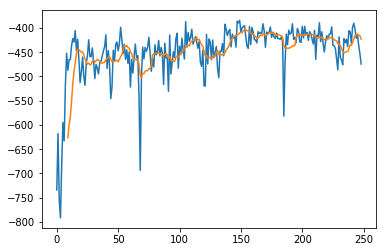

/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  


count    249.000000
mean    -447.931198
std       56.135699
min     -791.690903
25%     -463.194991
50%     -434.317354
75%     -415.650857
max     -384.139785
dtype: float64


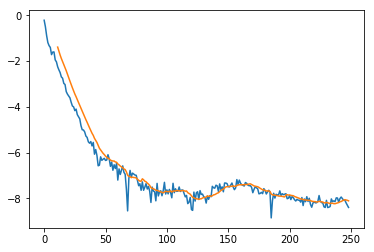

count    249.000000
mean      -6.921336
std        1.773563
min       -8.850431
25%       -7.955943
50%       -7.611437
75%       -6.769187
max       -0.216311
dtype: float64


-474.39926510940995

In [43]:
rr = pd.Series(rewards_list)
plt.plot(rr.index, rr)
plt.plot(rr.index, pd.rolling_mean(rr, 10))
plt.show()
print(rr.describe())
qq = pd.Series(mean_Qs)
plt.plot(qq.index, qq)
plt.plot(qq.index, pd.rolling_mean(qq, roll_window))
plt.show()
print(qq.describe())
rr.values[-1]

In [ ]:
# An agent implementing the policy that maximizes the estimated action-value (no exploring)
class RLAgent(object):
    def __init__(self, qnetwork):
        self.qnetwork = qnetwork
        self.first = True
    def choose_action(self, state):
        if not self.first:
            feed = {self.qnetwork.inputs_: [list(state.values())]}
            Qs = sess.run(self.qnetwork.output, feed_dict=feed)
            action = np.argmax(Qs)
            action_oh = np.zeros(4)
            action_oh[action] = 1
        else:
            action_oh = [0,0,0,1]
            self.first = False
        return action_oh
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    rl_rewards = run_episode(Environment(speeds, paradas, route), RLAgent(mainQN))

INFO:tensorflow:Restoring parameters from checkpoints/qnetwork.ckpt


/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.


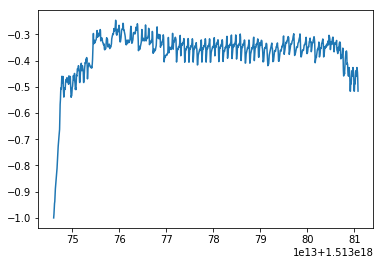

-398.74009952049619

In [45]:
plt.plot(rewards_df.index, rl_rewards)
plt.show()
sum(rl_rewards)

In [46]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('best_qnet'))
    rl_sim = sim_episode(Environment(speeds, paradas, route), RLAgent(mainQN), start=start)
rl_sim

INFO:tensorflow:Restoring parameters from best_qnet/qnetwork.ckpt


/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.6.2/envs/wawa-mi/lib/python3.6/site-packages/ipykernel_launcher.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.


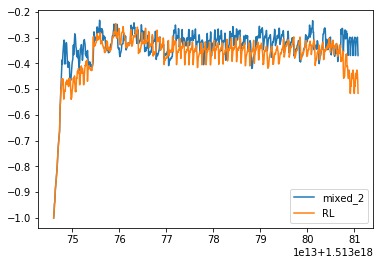

In [47]:
# The agent has similar performance than the best "mixed" strategy found (results may vary depending on training randomness)
plt.close()
plt.plot(rewards_df.index, rewards_mixed_df["mixed_2"], label="mixed_2")
plt.plot(rewards_df.index, rl_rewards, label="RL")
plt.legend()
plt.show()

In [64]:
with tf.Session() as sess, open("data/network_params", "w") as out:
    saver.restore(sess, tf.train.latest_checkpoint('best_qnet'))
    main_vars = tf.trainable_variables("main")
    _vars = {var.name: sess.run(var).tolist() for var in main_vars}
    json.dump(_vars, out)

INFO:tensorflow:Restoring parameters from best_qnet/qnetwork.ckpt
